<a href="https://colab.research.google.com/github/rajiv-ranjan/cds-mini-projects/blob/saif/M3_NB_MiniProject_3_Video_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science

##  A program by IISc and TalentSprint

### Mini Project Notebook: Video based Action Classification using LSTM

## Learning Objectives

At the end of the experiment, you will be able to :

* extract frames out of a video
* build the CNN model to extract features from the video frames
* train LSTM/GRU model to perform action classification

## Information

**Background:** The CNN LSTM architecture involves using Convolutional Neural Network (CNN) layers for feature extraction on input data combined with LSTMs to support sequence prediction.

CNN LSTMs were developed for visual time series prediction problems and the application of generating textual descriptions from sequences of images (e.g. videos). Specifically, the problems of:



*   Activity Recognition: Generating a textual description of an activity demonstrated in a sequence of images
*   Image Description: Generating a textual description of a single image.
*   Video Description: Generating a textual description of a sequence of images.

**Applications:** Applications such as surveillance, video retrieval and
human-computer interaction require methods for recognizing human actions in various scenarios. In the area of robotics, the tasks of
autonomous navigation or social interaction could also take advantage of the knowledge extracted
from live video recordings. Typical scenarios
include scenes with cluttered, moving backgrounds, nonstationary camera, scale variations, individual variations in
appearance and cloth of people, changes in light and view
point and so forth. All of these conditions introduce challenging problems that can be addressed using deep learning (computer vision) models.

## Dataset



**Dataset:** This dataset consists of labelled videos of 6 human actions (walking, jogging, running, boxing, hand waving and hand clapping) performed several times by 25 subjects in four different scenarios: outdoors s1, outdoors with scale variation s2, outdoors with different clothes s3 and indoors s4 as illustrated below.

![img](https://cdn.iisc.talentsprint.com/CDS/Images/actions.gif)

All sequences were taken over homogeneous backgrounds with a static camera with 25fps frame rate. The sequences were downsampled to the spatial resolution of 160x120 pixels and have a length of four seconds in average. In summary, there are 25x6x4=600 video files for each combination of 25 subjects, 6 actions and 4 scenarios. For this mini-project we have randomly selected 20% of the data as test set.

Dataset source: https://www.csc.kth.se/cvap/actions/

**Methodology:**

When performing image classification, we input an image to our CNN; Obtain the predictions from the CNN;
Choose the label with the largest corresponding probability


Since a video is just a series of image frames, in a video classification, we Loop over all frames in the video file;
For each frame, pass the frame through the CNN; Classify each frame individually and independently of each other; Choose the label with the largest corresponding probability;
Label the frame and write the output frame to disk

Refer this [Video Classification using Keras](https://medium.com/video-classification-using-keras-and-tensorflow/action-recognition-and-video-classification-using-keras-and-tensorflow-56badcbe5f77) for complete understanding and implementation example of video classification.

## Problem Statement

Train a CNN-LSTM based deep neural net to recognize the action being performed in a video

## Grading = 10 Points

### Install and re-start the runtime

In [1]:
!pip3 install imageio==2.4.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 23.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for imageio: filename=imageio-2.4.1-py3-none-any.whl size=3303884 sha256=76486e234f5f9bfc319b73d081533e39f84cec298d61e80e530d1e570d5b93b2
  Stored in directory: /root/.cache/pip/wheels/1b/28/50/248b15750b57c6b163d89d265f242e9cf6bce0bedfea3120aa
Successfully built imageio
  Attempting uninstall: imageio
    Found existing installation: imageio 2.37.0
    Uninstalling imageio-2.37.0:
      Successfully uninstalled imageio-2.37.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.25.2 requires imageio!=2.35.0,>=2.33, but you have imageio 2.4.1 which is incompatible.
moviepy 1.0.3 requires imageio<3.0,>=2.5; python_version >= "3.4", but you have imageio 2.4.1 which is incompatible.


In [2]:
#@title Download Dataset
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/Actions.zip
!unzip -qq Actions.zip
print("Dataset downloaded successfully!!")

Dataset downloaded successfully!!


### Import required packages

In [9]:
import keras
from keras import applications
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import *
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Input
#from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D
from keras.layers import GRU, Dense, Dropout
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D
from tensorflow.keras.optimizers import Adam

import os, glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [7]:
from keras.layers import GlobalAveragePooling2D

### Load the data and generate frames of video (2 points)

Detecting an action is possible by analyzing a series of images (that we name “frames”) that are taken in time.

Hint: Refer data preparation section in [keras_video_classification](https://keras.io/examples/vision/video_classification/)


In [40]:
data_dir = "/content/Actions/train/"
test_data_dir = "/content/Actions/test/"
# YOUR CODE HERE
IMG_SIZE = 128

def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

def load_video(path, max_frames=0):#, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            #frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)
            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

def load_videos_from_directory(data_dir, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    videos = []
    labels = []
    class_names = os.listdir(data_dir)

    for class_id, class_name in enumerate(class_names):
        class_folder = os.path.join(data_dir, class_name)
        if os.path.isdir(class_folder):
            video_files = [f for f in os.listdir(class_folder) if f.endswith(('.avi'))]
            for video_file in video_files:
                video_path = os.path.join(class_folder, video_file)
                frames = load_video(video_path, max_frames)#, resize)
                if len(frames) > 0:
                    videos.append(frames)
                    labels.append(class_id)
    return np.array(videos), np.array(labels)

train_videos, train_labels = load_videos_from_directory(data_dir, max_frames=30, resize=(IMG_SIZE, IMG_SIZE))
test_videos, test_labels = load_videos_from_directory(test_data_dir, max_frames=30, resize=(IMG_SIZE, IMG_SIZE))


(479, 30, 120, 120, 3)
(120, 30, 120, 120, 3)


In [42]:
print("Train video Shape:", train_videos.shape)
print("Test video Shape:", test_videos.shape)

Train video Shape: (479, 30, 120, 120, 3)
Test video Shape: (120, 30, 120, 120, 3)


#### Visualize the frames and analyze the object in each frame. (1 point)

* Plot the frames of each class per row (6 rows)
* Plot the title as label on each subplot

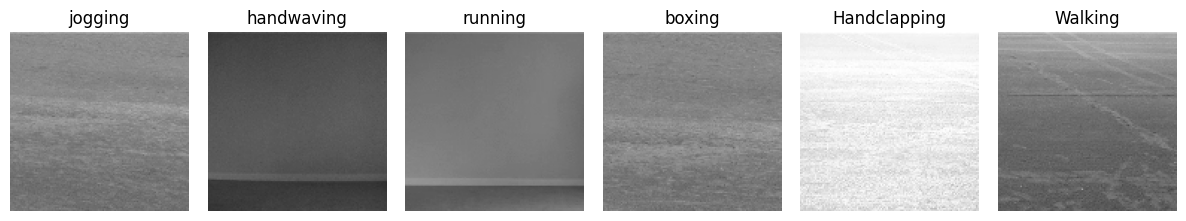

In [46]:
# YOUR CODE HERE
class_names = os.listdir(data_dir)
num_classes = len(class_names)

# Plot
plt.figure(figsize=(12, 12))
for i in range(num_classes):
    plt.subplot(num_classes, 6, i + 1)
    plt.title(class_names[i])
    plt.imshow(train_videos[i][0])
    plt.axis('off')

plt.tight_layout()
plt.show()

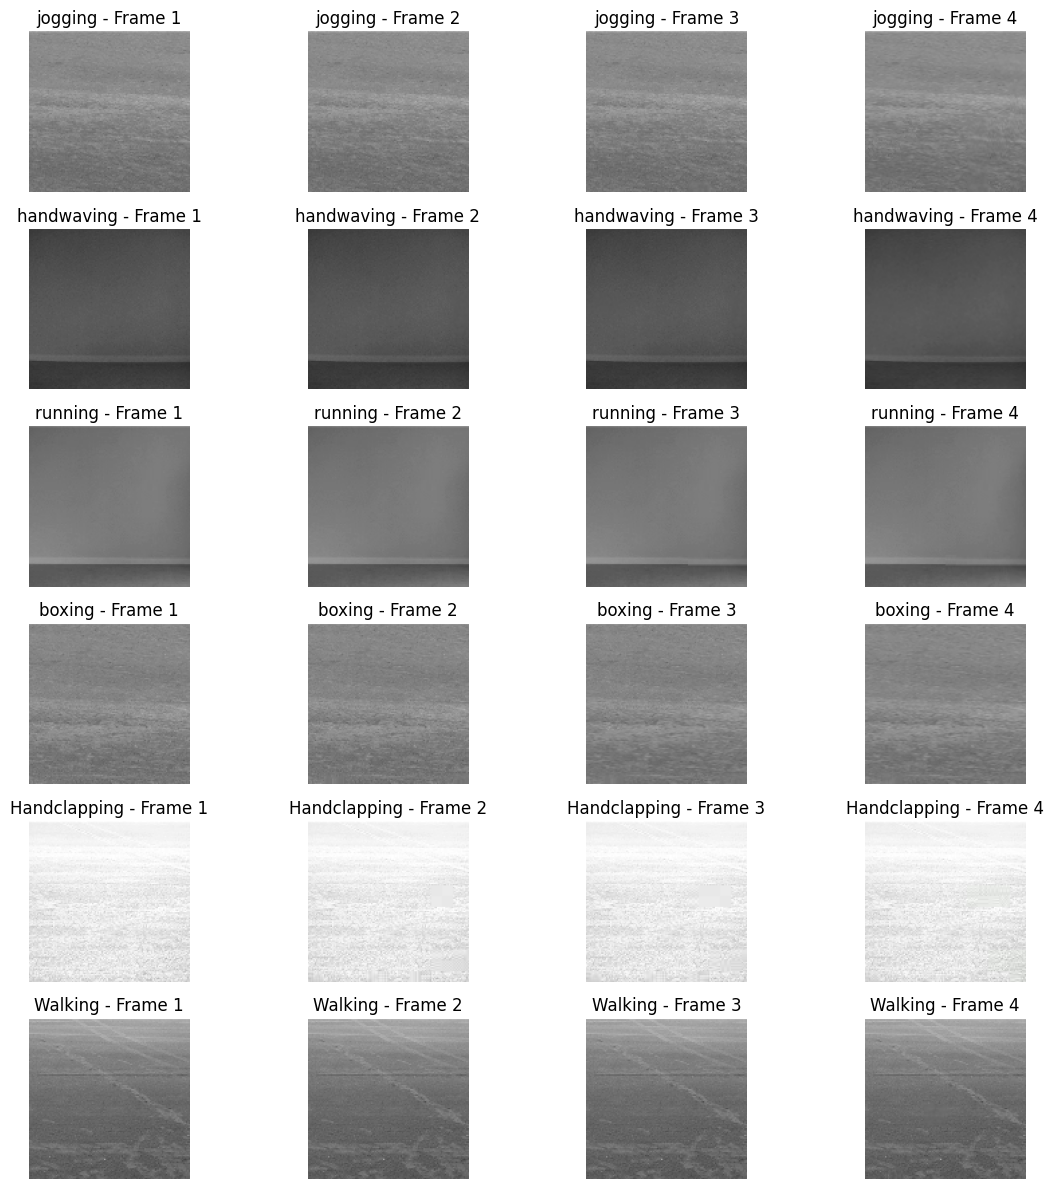

In [53]:
class_names = os.listdir(data_dir)

num_classes = len(class_names)
frames_per_class = 4

# Plot
plt.figure(figsize=(12, 12))
for j in range(frames_per_class):
    for i in range(num_classes):
        plt.subplot(num_classes, frames_per_class, i * frames_per_class + j + 1)
        plt.title(f"{class_names[i]} - Frame {j+1}")

        plt.imshow(train_videos[i][j % len(train_videos[i])])
        plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

### Create the Neural Network (4 points)

We can build the model in several ways. We can use a well-known model that we inject in time distributed layer, or we can build our own.

With custom ConvNet each input image of the sequence must pass to a convolutional network. The goal is to train that model for each frame and then decide the class to infer.

* Use ConvNet and Time distributed to detect features.
* Inject the Time distributed output to GRU or LSTM to treat as a time series.
* Apply a DenseNet to take the decision and classify.

##### Build the ConvNet for the feature extraction, GRU LSTM layers as a time series and Dense layers for classification

In [ ]:
# YOUR CODE HERE


#### Setup the parameters and train the model with epochs, batch wise

* Use train data to fit the model and test data for validation
* Configure batch size and epochs
* Plot the loss of train and test data

In [ ]:
# Note: There will be a high memory requirement for the training steps below.
# You should work on a GPU/TPU based runtime. See 'Change Runtime' in Colab
# Training time for each epoch could be ~30 mins
# To save and re-load your model later, see the reference below:
# https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/save_and_load.ipynb

# YOUR CODE HERE

### Use pre-trained model for feature extraction (3 points)

To create a deep learning network for video classification:

* Convert videos to sequences of feature vectors using a pretrained convolutional neural network, such as VGG16, to extract features from each frame.

* Train an LSTM network on the sequences to predict the video labels.

* Assemble a network that classifies videos directly by combining layers from both networks.

Hint: [VGG-16 CNN and LSTM](https://riptutorial.com/keras/example/29812/vgg-16-cnn-and-lstm-for-video-classification)

#### Load and fine-tune the pre-trained model

In [ ]:
# YOUR CODE HERE

#### Setup the parameters and train the model with epochs, batch wise

* Use train data to fit the model and test data for validation
* Configure batch size and epochs
* Plot the loss of train and test data

In [ ]:
# YOUR CODE HERE

### Report Analysis

* Discuss on FPS, Number of frames and duration of each video
* Analyze the impact of the LSTM, GRU and TimeDistributed layers
* Discuss about the model convergence using pre-trained and ConvNet
* *Additional Reading*: Read and discuss about the use of Conv3D in video classification